# Data imputation
[TOC]

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from mlens.visualization import pca_comp_plot
from matplotlib import pyplot as plt

seed = 0
np.random.seed(seed)

mean = [64.44, 0.34, 37.60, 0.51, 0.50, 7.06, 40.68, 602.52, 368.17, 2.5e3, 92.54, 72.09, 91.92, 7.45, 0.28, 0.02]
std = [15.05, 0.34*(1-0.34), 0.97, 0.51*(1-0.51), 0.50*(1-0.50), 3.53, 66.93, 158.36, 235.22, 6743.13, 7.00, 26.11, 8.24, 0.06, 0.28*(1-0.28), 0.02*(1-0.02)]

def fill_dataset(dataset, feature, filled_feature, save_path):
    filled_dataset = dataset.copy()
    filled_dataset[feature] = filled_feature
    filled_dataset.to_csv(save_path, index=None)
    return filled_dataset

def get_models():
    nb = GaussianNB()
    svc = SVC(kernel='rbf', C=100, gamma=1e-3, probability=True, class_weight='balanced')
    knn = KNeighborsClassifier(n_neighbors=8)
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((32, 64, 16), solver='lbfgs', activation='relu', random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=64, random_state=seed)
    rf = RandomForestClassifier(n_estimators=64, max_features=2, random_state=seed)
    ab = AdaBoostClassifier(n_estimators=64, random_state=seed)
    xgb = XGBClassifier(random_state=seed)        
    models = {'svm': svc, 
              'knn': knn, 
              'naive bayes': nb,
              'mlp': nn,
              'random forest': rf,
              'gradient boost': gb,
              'logistic': lr,
              'adaboost': ab,
              'xgboost': xgb, 
             }
    return models

def sensitivity_specificity(cm):
    return cm[1, 1] / np.sum(cm[1]), cm[0, 0] / np.sum(cm[0])

def get_severity(Prognosis):
    if Prognosis == 'MILD':
        return 0
    elif Prognosis == 'SEVERE':
        return 1

def train_predict(model_list):
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            print('no sample weight')
            m.fit(x_train, y_train)
        try:
            print('\n', name, m.feature_importances_)
        except:
            print('no feature importances')
        P.iloc[:, i] = m.predict_proba(x_test)[:, 1]
        cols.append(name)
        print("done")
    
    P.columns = cols
    print("Done.\n")
    return P

def cross_val_models(model_list, cv=5, scoring='accuracy'):
    P = np.zeros((cv, len(model_list)))
    P = pd.DataFrame(P)

    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        P.iloc[:, i] = cross_val_score(m, X, y, cv=cv, scoring=scoring)
        cols.append(name)
        print("done")
    P.columns = cols
    print('Done.\n')
    return P

def cross_val_acc(P, scoring='ACC'):
    for m in P.columns:
        score = np.mean(P.loc[:, m])
        std = 2 * np.std(P.loc[:, m])
        print('{} {} Result {} +/- {}'.format(m, scoring, score, std))

def score_models(P, y):
    print('ROC AUC SCORE')
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print('ACC SCORE')
    for m in P.columns:
        score = accuracy_score(y, np.float32(P.loc[:, m]>=0.5))
        print("%-26s: %.3f" % (m, score))

def plot_roc_curve(y_test, P_base_learners, P_ensemble, labels, ens_label):
    plt.plot([0, 1], [0, 1], 'k--')
    #cm = [plt.cm.gray(i) for i in np.linspace(0, 1.0, P_base_learners.shape[1])]
    cm = sns.color_palette("Blues", P_base_learners.shape[1])
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i])
        
    fpr, tpr, _ = roc_curve(y_test, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c='red')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
def train_base_learners(base_learners, x_train, y_train):
    print('Fitting models')
    feature_importances = {}
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            m.fit(x_train, y_train)
            print('no sample_weight')
        try:
            feature_importances.update({name: m.feature_importances_})
        except:
            print('no feature importances')
    print('done.')
    return feature_importances

def predict_base_learners(base_learners, x):
    P = np.zeros((x.shape[0], len(base_learners)))
    print('Generating base learner predictions.')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        p = m.predict_proba(x)
        P[:, i] = p[:, 1]
    print('done.')
    return P

def ensemble_predict(base_learners, meta_learner, x):
    P_pred = predict_base_learners(base_learners, x)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

def z_score_normalize(X, mean=mean, std=std):
    return (X - mean)/std

def z_score_denormalize(X, mean=mean, std=std):
    return (X * std) + mean

Using TensorFlow backend.
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

## Read data

In [2]:
train_data_path = './trainSet/trainSet.txt'
test_data_path = './testSet/testSet.txt'

In [3]:
train_dataset = pd.read_csv(train_data_path, sep=',')
train_dataset['severity'] = train_dataset['Prognosis'].map(get_severity)
test_dataset = pd.read_csv(test_data_path, sep=',')

feature = [
    'Age', 
    'Sex', 
    'Temp_C', 
    'Cough', 
    'DifficultyInBreathing', 
    'WBC', 
    'CRP',
    'Fibrinogen', 
    'LDH',
    'Ddimer', 
    'Ox_percentage',
    'PaO2', 
    'SaO2',
    'pH',
    'CardiovascularDisease',
    'RespiratoryFailure',
]

y = np.array(train_dataset['severity'])

## Imputation
### Impute testing dataset
- Filled NaN data using [method] based on concatenation of trainSet.txt & testSet.txt.
- There are columns filled with **NaN** so we need **concatenation** of trainSet.txt & testSet.txt, otherwise nothing meaningful imputation can be obtained.

In [4]:
concat_feature = pd.concat([test_dataset[feature], train_dataset[feature]])
test_dataset_len = len(test_dataset)
train_dataset_len = len(train_dataset)

In [5]:
X_incomplete = concat_feature
X_incomplete = np.array(X_incomplete)
X_incomplete = z_score_normalize(X_incomplete)

X_filled_knn_3 = KNN(k=3).fit_transform(X_incomplete)
X_filled_knn_6 = KNN(k=6).fit_transform(X_incomplete)
X_filled_knn_9 = KNN(k=9).fit_transform(X_incomplete)

# Not suitable for large scale matrix
# X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)

X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)

test_dataset_filled_knn_3 = fill_dataset(test_dataset, feature, z_score_denormalize(X_filled_knn_3[:test_dataset_len]), './csv/filled_testSet/filled_knn_3_testSet.txt')
test_dataset_filled_knn_6 = fill_dataset(test_dataset, feature, z_score_denormalize(X_filled_knn_6[:test_dataset_len]), './csv/filled_testSet/filled_knn_6_testSet.txt')
test_dataset_filled_knn_9 = fill_dataset(test_dataset, feature, z_score_denormalize(X_filled_knn_9[:test_dataset_len]), './csv/filled_testSet/filled_knn_9_testSet.txt')
test_dataset_filled_softimpute = fill_dataset(test_dataset, feature, z_score_denormalize(X_filled_softimpute[:test_dataset_len]), './csv/filled_testSet/filled_softimpute_testSet.txt')

Imputing row 1/983 with 4 missing, elapsed time: 0.165
Imputing row 101/983 with 9 missing, elapsed time: 0.176
Imputing row 201/983 with 4 missing, elapsed time: 0.181
Imputing row 301/983 with 6 missing, elapsed time: 0.186
Imputing row 401/983 with 3 missing, elapsed time: 0.192
Imputing row 501/983 with 1 missing, elapsed time: 0.195
Imputing row 601/983 with 3 missing, elapsed time: 0.201
Imputing row 701/983 with 4 missing, elapsed time: 0.206
Imputing row 801/983 with 3 missing, elapsed time: 0.211
Imputing row 901/983 with 1 missing, elapsed time: 0.216
Imputing row 1/983 with 4 missing, elapsed time: 0.165
Imputing row 101/983 with 9 missing, elapsed time: 0.174
Imputing row 201/983 with 4 missing, elapsed time: 0.180
Imputing row 301/983 with 6 missing, elapsed time: 0.185
Imputing row 401/983 with 3 missing, elapsed time: 0.190
Imputing row 501/983 with 1 missing, elapsed time: 0.195
Imputing row 601/983 with 3 missing, elapsed time: 0.200
Imputing row 701/983 with 4 missing

[SoftImpute] Iter 84: observed MAE=0.023578 rank=15
[SoftImpute] Iter 85: observed MAE=0.023578 rank=15
[SoftImpute] Iter 86: observed MAE=0.023578 rank=15
[SoftImpute] Iter 87: observed MAE=0.023579 rank=15
[SoftImpute] Iter 88: observed MAE=0.023579 rank=15
[SoftImpute] Iter 89: observed MAE=0.023579 rank=15
[SoftImpute] Iter 90: observed MAE=0.023580 rank=15
[SoftImpute] Iter 91: observed MAE=0.023580 rank=15
[SoftImpute] Iter 92: observed MAE=0.023580 rank=15
[SoftImpute] Iter 93: observed MAE=0.023580 rank=15
[SoftImpute] Iter 94: observed MAE=0.023581 rank=15
[SoftImpute] Iter 95: observed MAE=0.023581 rank=15
[SoftImpute] Iter 96: observed MAE=0.023581 rank=15
[SoftImpute] Iter 97: observed MAE=0.023581 rank=15
[SoftImpute] Iter 98: observed MAE=0.023582 rank=15
[SoftImpute] Iter 99: observed MAE=0.023582 rank=15
[SoftImpute] Iter 100: observed MAE=0.023582 rank=15
[SoftImpute] Stopped after iteration 100 for lambda=0.825994


### Impute training dataset

In [6]:
X_incomplete = train_dataset[feature]
X_incomplete = np.array(X_incomplete)
X_incomplete = z_score_normalize(X_incomplete)
X_filled_knn_3 = KNN(k=3).fit_transform(X_incomplete)
X_filled_knn_6 = KNN(k=6).fit_transform(X_incomplete)
X_filled_knn_9 = KNN(k=9).fit_transform(X_incomplete)

# Not suitable for large scale matrix
# X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)

X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)

fill_dataset(train_dataset, feature, z_score_denormalize(X_filled_knn_3), './csv/filled_trainSet/filled_knn_3_trainSet.txt')
fill_dataset(train_dataset, feature, z_score_denormalize(X_filled_knn_6), './csv/filled_trainSet/filled_knn_6_trainSet.txt')
fill_dataset(train_dataset, feature, z_score_denormalize(X_filled_knn_9), './csv/filled_trainSet/filled_knn_9_trainSet.txt')
fill_dataset(train_dataset, feature, z_score_denormalize(X_filled_softimpute), './csv/filled_trainSet/filled_softimpute_trainSet.txt')

Imputing row 1/863 with 4 missing, elapsed time: 0.125
Imputing row 101/863 with 1 missing, elapsed time: 0.130
Imputing row 201/863 with 2 missing, elapsed time: 0.135
Imputing row 301/863 with 3 missing, elapsed time: 0.141
Imputing row 401/863 with 5 missing, elapsed time: 0.145
Imputing row 501/863 with 3 missing, elapsed time: 0.150
Imputing row 601/863 with 4 missing, elapsed time: 0.155
Imputing row 701/863 with 2 missing, elapsed time: 0.160
Imputing row 801/863 with 2 missing, elapsed time: 0.165
Imputing row 1/863 with 4 missing, elapsed time: 0.122
Imputing row 101/863 with 1 missing, elapsed time: 0.127
Imputing row 201/863 with 2 missing, elapsed time: 0.132
Imputing row 301/863 with 3 missing, elapsed time: 0.136
Imputing row 401/863 with 5 missing, elapsed time: 0.142
Imputing row 501/863 with 3 missing, elapsed time: 0.147
Imputing row 601/863 with 4 missing, elapsed time: 0.151
Imputing row 701/863 with 2 missing, elapsed time: 0.157
Imputing row 801/863 with 2 missing

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,...,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis,severity
0,P_131,P_131.png,D,33.195797,0.187378,39.540229,0.753616,0.272696,6.093142,69.719726,...,496.069339,449.448694,93.985011,69.231114,93.476472,7.454321,0.164870,0.021048,MILD,0
1,P_132,P_132.png,D,56.532254,0.163976,36.868540,0.217071,0.239460,15.473850,112.445336,...,377.282076,829.206335,93.716961,80.397610,100.903407,7.387528,0.146310,0.021521,MILD,0
2,P_195,P_195.png,D,78.127837,0.175178,37.609290,0.704753,0.262671,5.578155,166.274022,...,317.456699,-3524.076584,91.636093,53.125551,92.741772,7.333317,0.617803,0.014877,SEVERE,1
3,P_193,P_193.png,D,79.495954,0.142161,37.647242,0.700321,0.220308,6.152517,221.024658,...,487.694021,2065.672709,94.060177,52.317993,93.319404,7.423369,0.122380,0.022769,SEVERE,1
4,P_140,P_140.png,D,60.099710,0.777646,36.706426,0.824099,0.187912,6.588651,10.085499,...,293.305424,-1711.130157,91.842556,81.080565,103.162470,7.444999,0.118955,0.018553,MILD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,P_1_12,P_1_12.png,F,50.906657,0.202061,37.631982,0.287455,0.704429,15.758303,11.591722,...,364.576616,10088.772403,92.775037,74.781216,91.190706,7.452693,0.172861,0.008019,SEVERE,1
859,P_1_8,P_1_8.png,F,56.559496,0.159644,37.685975,0.797569,0.231428,4.728313,-4.753165,...,673.438149,2403.719977,92.427919,69.328531,92.344096,7.451632,0.143927,0.021591,SEVERE,1
860,P_1_10,P_1_10.png,F,38.587343,0.207053,37.559318,0.272511,0.825599,9.784796,14.395177,...,413.931871,8779.018952,93.537639,74.145853,91.578637,7.449117,0.184535,0.041979,MILD,0
861,P_1_26,P_1_26.png,F,86.273524,0.563998,37.796539,0.307712,0.683235,13.986624,-13.617817,...,345.121328,2402.728337,91.524438,73.120925,91.285873,7.325461,0.182159,0.008273,SEVERE,1


## Clinical data prediction
Select **imputation** method you want to verify here.

In [7]:
# X = X_filled_knn_3.copy()
# X = X_filled_knn_6.copy()
# X = X_filled_knn_9.copy()
X = X_filled_softimpute.copy()

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


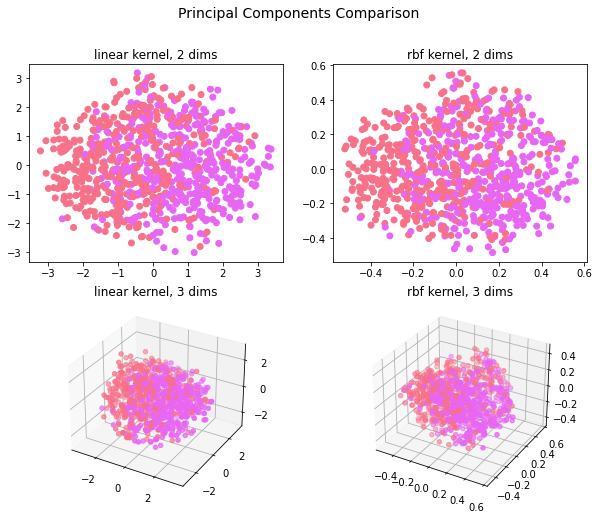

[<AxesSubplot:title={'center':'linear kernel, 2 dims'}>,
 <AxesSubplot:title={'center':'rbf kernel, 2 dims'}>,
 <Axes3DSubplot:title={'center':'linear kernel, 3 dims'}>,
 <Axes3DSubplot:title={'center':'rbf kernel, 3 dims'}>]

In [8]:
pca_comp_plot(X, y)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print('样本集大小：',X.shape,y.shape)
print('训练集大小：',x_train.shape,y_train.shape)  # 训练集样本大小
print('测试集大小：',x_test.shape,y_test.shape)  # 测试集样本大小

样本集大小： (863, 16) (863,)
训练集大小： (690, 16) (690,)
测试集大小： (173, 16) (173,)


In [10]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models...
svm... no sample weight
no feature importances
done
knn... no sample weight
no feature importances
done
naive bayes... no sample weight
no feature importances
done
mlp... no sample weight
no feature importances
done
random forest... no sample weight

 random forest [0.07101597 0.05918919 0.04948661 0.04854036 0.0615986  0.04802947
 0.0522616  0.05873071 0.08035426 0.04198772 0.09226251 0.07402421
 0.10831895 0.04635287 0.05272883 0.05511815]
done
gradient boost... no sample weight

 gradient boost [0.05982287 0.02848868 0.03889235 0.03917102 0.02669864 0.03727632
 0.04214682 0.01893014 0.10373528 0.01135773 0.08213517 0.09643358
 0.26785138 0.0290232  0.04945658 0.06858025]
done
logistic... no sample weight
no feature importances
done
adaboost... no sample weight

 adaboost [0.0625   0.015625 0.078125 0.       0.09375  0.03125  0.0625   0.03125
 0.140625 0.046875 0.0625   0.046875 0.0625   0.046875 0.109375 0.109375]
done
xgboost... no sample weight

 xgboost [0.06120

In [11]:
models = get_models()
cv_results=cross_val_models(models)
cross_val_acc(cv_results)

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gradient boost... done
logistic... done
adaboost... done
xgboost... done
Done.

svm ACC Result 0.7369740556526414 +/- 0.06408856320541854
knn ACC Result 0.7496773759913966 +/- 0.030788567596616353
naive bayes ACC Result 0.7335058475601559 +/- 0.018337808198934043
mlp ACC Result 0.718349240489313 +/- 0.09759164619271891
random forest ACC Result 0.7578101895416051 +/- 0.06004376959117899
gradient boost ACC Result 0.7381570103508536 +/- 0.059667085289696456
logistic ACC Result 0.7462226105659362 +/- 0.06592437412510327
adaboost ACC Result 0.7242304073128109 +/- 0.0359104036414424
xgboost ACC Result 0.7195926871891383 +/- 0.027573213774097945


In [12]:
cv_results

,svm,knn,naive bayes,mlp,random forest,gradient boost,logistic,adaboost,xgboost
0,0.722543,0.763006,0.728324,0.757225,0.780347,0.710983,0.757225,0.699422,0.705202
1,0.716763,0.751445,0.722543,0.791908,0.745665,0.751445,0.710983,0.716763,0.734104
2,0.763006,0.763006,0.734104,0.670520,0.757225,0.722543,0.780347,0.745665,0.710983
3,0.697674,0.720930,0.732558,0.668605,0.709302,0.715116,0.703488,0.715116,0.709302
4,0.784884,0.750000,0.750000,0.703488,0.796512,0.790698,0.779070,0.744186,0.738372


In [13]:
cv_results_roc=cross_val_models(models, scoring='roc_auc')
cross_val_acc(cv_results_roc, scoring='ROC AUC')

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gradient boost... done
logistic... done
adaboost... done
xgboost... done
Done.

svm ROC AUC Result 0.81727764460016 +/- 0.037529235702127524
knn ROC AUC Result 0.8084717868338558 +/- 0.028979931740809803
naive bayes ROC AUC Result 0.8131643002028397 +/- 0.0288728150577375
mlp ROC AUC Result 0.7758113590263692 +/- 0.08136527485552646
random forest ROC AUC Result 0.8240956727518596 +/- 0.03543784362903007
gradient boost ROC AUC Result 0.8116709693281701 +/- 0.041733039993725754
logistic ROC AUC Result 0.8160412440838403 +/- 0.03646275361978252
adaboost ROC AUC Result 0.7771115311328293 +/- 0.07686081248743988
xgboost ROC AUC Result 0.7958749769500277 +/- 0.01780279486500456


In [14]:
print("Voting ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))
print("Voting ACC score: %.3f" % accuracy_score(y_test, np.float32(P.mean(axis=1) > 0.5)))

Voting ROC-AUC score: 0.835
Voting ACC score: 0.728


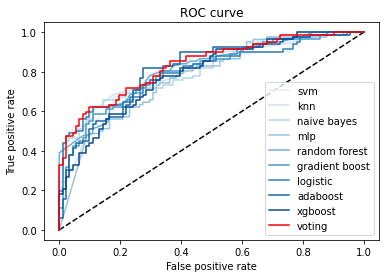

In [15]:
plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), 'voting')

In [16]:
base_learners = get_models()

In [17]:
meta_learner = GradientBoostingClassifier(
   n_estimators=128,
   loss="exponential",
   max_features=4,
   max_depth=3,
   subsample=0.5,
   learning_rate=0.005, 
   random_state=seed
)

In [18]:
train_base_learners(base_learners, x_train, y_train)

Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.


{'random forest': array([0.07101597, 0.05918919, 0.04948661, 0.04854036, 0.0615986 ,
        0.04802947, 0.0522616 , 0.05873071, 0.08035426, 0.04198772,
        0.09226251, 0.07402421, 0.10831895, 0.04635287, 0.05272883,
        0.05511815]),
 'gradient boost': array([0.05982287, 0.02848868, 0.03889235, 0.03917102, 0.02669864,
        0.03727632, 0.04214682, 0.01893014, 0.10373528, 0.01135773,
        0.08213517, 0.09643358, 0.26785138, 0.0290232 , 0.04945658,
        0.06858025]),
 'adaboost': array([0.0625  , 0.015625, 0.078125, 0.      , 0.09375 , 0.03125 ,
        0.0625  , 0.03125 , 0.140625, 0.046875, 0.0625  , 0.046875,
        0.0625  , 0.046875, 0.109375, 0.109375]),
 'xgboost': array([0.06120204, 0.04403174, 0.04119398, 0.05767786, 0.03699848,
        0.03552675, 0.04424962, 0.04580368, 0.06878553, 0.03740954,
        0.06383199, 0.06217767, 0.25023514, 0.03966242, 0.04454956,
        0.0666639 ], dtype=float32)}

In [19]:
P_base = predict_base_learners(base_learners, x_train)
P_test = predict_base_learners(base_learners, x_test)

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.


In [20]:
meta_learner.fit(P_base, y_train)

GradientBoostingClassifier(learning_rate=0.005, loss='exponential',
                           max_features=4, n_estimators=128, random_state=0,
                           subsample=0.5)

In [21]:
P_pred, p = ensemble_predict(base_learners, meta_learner, x_test)
print("\nStacking ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
print("Stacking ACC score: %.3f" % accuracy_score(y_test, np.float32(p > 0.5)))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.

Stacking ROC-AUC score: 0.776
Stacking ACC score: 0.699


In [22]:
c = 0
for k, v in base_learners.items():
    print("{} ROC-AUC score: %.3f".format(k) % roc_auc_score(y_test, P_pred[:, c]))
    print("{} ACC score: %.3f \n".format(k) % accuracy_score(y_test, np.float32(P_pred[:, c] > 0.5)))
    c = c + 1

svm ROC-AUC score: 0.816
svm ACC score: 0.734 

knn ROC-AUC score: 0.805
knn ACC score: 0.757 

naive bayes ROC-AUC score: 0.812
naive bayes ACC score: 0.734 

mlp ROC-AUC score: 0.772
mlp ACC score: 0.705 

random forest ROC-AUC score: 0.814
random forest ACC score: 0.734 

gradient boost ROC-AUC score: 0.804
gradient boost ACC score: 0.717 

logistic ROC-AUC score: 0.808
logistic ACC score: 0.717 

adaboost ROC-AUC score: 0.814
adaboost ACC score: 0.740 

xgboost ROC-AUC score: 0.790
xgboost ACC score: 0.699 



In [23]:
index = train_dataset[feature].index

## 5-fold validation

In [24]:
idx = list(index)
np.random.shuffle(idx)
X_ = X[idx]
y_ = y[idx]
cls_data_voting = train_dataset.copy().reset_index(drop=True)
cls_data_voting = cls_data_voting.iloc[idx]
cls_data_voting = cls_data_voting.reset_index(drop=True)
cv_scores_vote = []
feature_importances_list = []
prob = pd.DataFrame(columns=base_learners.keys(), dtype='float32')
for i, (train_idx, test_idx) in enumerate(KFold(5).split(X_)):
    fold_x_train, fold_y_train = X_[train_idx, :], y_[train_idx]
    fold_x_test, fold_y_test = X_[test_idx, :], y_[test_idx]
    
    base_learners = get_models()

    feature_importances = train_base_learners(base_learners, fold_x_train, fold_y_train)
    P_test = predict_base_learners(base_learners, fold_x_test)
    for i, model_name in zip(range(len(base_learners.keys())), base_learners.keys()):
        cls_data_voting.loc[test_idx, model_name] = P_test[:, i]
    
    p_vote = P_test.mean(axis=1)
    fold_y_pred = np.float32(p_vote > 0.5)
    
    acc = accuracy_score(fold_y_test, fold_y_pred)
    recall = recall_score(fold_y_test, fold_y_pred)
    cm = confusion_matrix(fold_y_test, fold_y_pred)
    roc = roc_auc_score(fold_y_test, p_vote)
    
    cls_data_voting.loc[test_idx, 'pred'] = fold_y_pred
    cls_data_voting.loc[test_idx, 'prob'] = p_vote
    prob = pd.concat([prob, pd.DataFrame(P_test, columns=base_learners.keys())])

    print("\nEnsemble ROC-AUC score: %.3f" % roc)
    print("Ensemble ACC score: %.3f" % acc)
    
    cv_scores_vote.append({'acc': acc, 'recall': recall, 'confusion_matrix': cm, 'roc_auc_score': roc})
    feature_importances_list.append(feature_importances)

Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.

Ensemble ROC-AUC score: 0.855
Ensemble ACC score: 0.746
Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.
Generating base learner predict

In [25]:
feature_stacking = pd.DataFrame(pd.DataFrame(feature_importances_list).sum().to_dict(), index=feature)
feature_stacking['sum'] = feature_stacking.sum(axis=1)
feature_stacking = feature_stacking.sort_values(by='sum')

In [26]:
# feature_stacking.to_csv('csv/feature_importance/filled_knn_3.csv')

In [27]:
pd.DataFrame(cv_scores_vote)

,acc,recall,confusion_matrix,roc_auc_score
0,0.745665,0.731707,"[[69, 22], [22, 60]]",0.854999
1,0.745665,0.766234,"[[70, 26], [18, 59]]",0.850244
2,0.745665,0.698925,"[[64, 16], [28, 65]]",0.818414
3,0.761628,0.747253,"[[63, 18], [23, 68]]",0.834080
4,0.750000,0.707317,"[[71, 19], [24, 58]]",0.826829


In [28]:
np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])

array([[337, 101],
       [115, 310]], dtype=int64)

Text(33.0, 0.5, 'True labels')

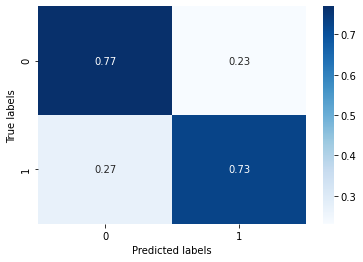

In [29]:
cm = np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, cmap='Blues', annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [30]:
cv_results['voting'] = pd.DataFrame(cv_scores_vote)['acc']
cv_results

,svm,knn,naive bayes,mlp,random forest,gradient boost,logistic,adaboost,xgboost,voting
0,0.722543,0.763006,0.728324,0.757225,0.780347,0.710983,0.757225,0.699422,0.705202,0.745665
1,0.716763,0.751445,0.722543,0.791908,0.745665,0.751445,0.710983,0.716763,0.734104,0.745665
2,0.763006,0.763006,0.734104,0.670520,0.757225,0.722543,0.780347,0.745665,0.710983,0.745665
3,0.697674,0.720930,0.732558,0.668605,0.709302,0.715116,0.703488,0.715116,0.709302,0.761628
4,0.784884,0.750000,0.750000,0.703488,0.796512,0.790698,0.779070,0.744186,0.738372,0.750000


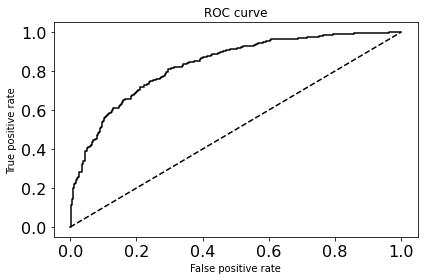

In [31]:
fpr, tpr, _ = roc_curve(cls_data_voting['severity'], cls_data_voting['prob'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Voting', c='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
#plt.legend()
plt.tick_params(labelsize=16)
plt.tight_layout()
#plt.savefig('fig/filled_knn_6.eps',format='eps')
#plt.savefig('fig/filled_knn_6.png', format='png')

In [32]:
thres = 0.50

In [33]:
acc = accuracy_score(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
recall = recall_score(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
cm = confusion_matrix(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
roc = roc_auc_score(cls_data_voting['severity'], cls_data_voting['prob'])
sensitivity, specificity = sensitivity_specificity(cm)

print('roc auc score: \t{}'.format(roc))
print('accuarcy: \t{}'.format(acc))
print('recall: \t{}'.format(recall))
print('sensitivity: \t{}'.format(sensitivity))
print('specificity: \t{}'.format(specificity))
print('confusion matrix: \n{}'.format(cm))

roc auc score: 	0.8327209239860328
accuarcy: 	0.7497103128621089
recall: 	0.7294117647058823
sensitivity: 	0.7294117647058823
specificity: 	0.769406392694064
confusion matrix: 
[[337 101]
 [115 310]]


In [34]:
results = pd.DataFrame(index=base_learners.keys(), columns=['roc', 'acc', 'recall', 'cm', 'sensitivity', 'specificity'], dtype='object')
for k in base_learners.keys():
    acc = accuracy_score(cls_data_voting['severity'], prob[k] > thres)
    recall = recall_score(cls_data_voting['severity'], prob[k] > thres)
    cm = confusion_matrix(cls_data_voting['severity'], prob[k] > thres)
    roc = roc_auc_score(cls_data_voting['severity'], prob[k])
    sensitivity, specificity = sensitivity_specificity(cm)
    results.loc[k, :] = [roc, acc, recall, cm, sensitivity, specificity]

C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

In [35]:
# results.to_csv('./csv/cross_validation_trainSet/filled_knn_3.csv')

[Text(0.5, 0, 'Classifcation Methods'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, '5-Fold Cross Validation Accuracy')]

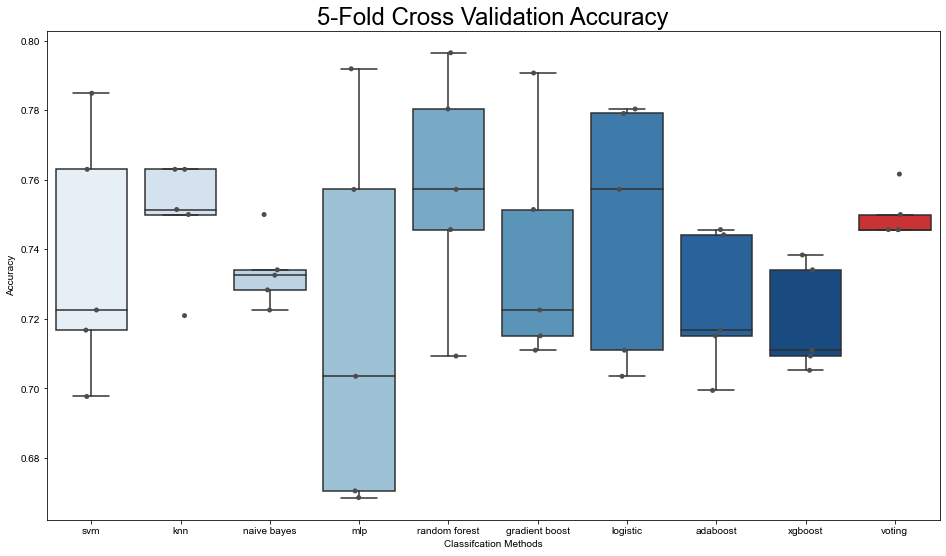

In [36]:
plt.subplots(figsize=(16, 9))
sns.set(style="ticks")
sns.set(font_scale=2.0)
colors = sns.color_palette("Blues", len(base_learners.keys()))
colors.append((0.8901960784313725, 0.10196078431372549, 0.10980392156862745))
dx = sns.boxplot(data=cv_results, palette=colors, boxprops=dict(alpha=1.0),showfliers = False)
dx = sns.stripplot(data=cv_results,
                   jitter=True,
                   color=".3",
                   dodge=True,
                   marker='o', 
                   alpha=1.0)
dx.set(xlabel='Classifcation Methods',ylabel='Accuracy', title='5-Fold Cross Validation Accuracy')

In [37]:
# P_test = predict_base_learners(base_learners, z_score_normalize(np.array(test_dataset_filled_softimpute[feature])))
# test_dataset_filled_softimpute['prediction_clinical'] = P_test.mean(axis=1)
# test_dataset_filled_softimpute.to_csv('./csv/prediction_testSet/filled_softimpute.txt')

In [38]:
# P_test = predict_base_learners(base_learners, z_score_normalize(np.array(test_dataset_filled_knn_9[feature])))
# test_dataset_filled_knn_9['prediction_clinical'] = P_test.mean(axis=1)
# test_dataset_filled_knn_9.to_csv('./csv/prediction_testSet/filled_knn_9.txt')

In [39]:
# print(X_filled_knn_3.mean(axis=0), '\n', X_filled_knn_3.std(axis=0))
# print(X_filled_knn_6.mean(axis=0), '\n',X_filled_knn_6.std(axis=0))
# print(X_filled_knn_6.mean(axis=0), '\n',X_filled_knn_6.std(axis=0))
# print(X_filled_softimpute.mean(axis=0), '\n',X_filled_softimpute.std(axis=0))